In [178]:
import os
import pickle
from itertools import chain, combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from scipy.stats import ttest_rel, shapiro, levene
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from ertk.classification import dataset_cross_validation, standard_class_scoring
from ertk.dataset import Dataset
from ertk.sklearn.models import get_sk_model
from ertk.config import get_arg_mapping
from ertk.train import ShuffleGroupKFold, get_cv_splitter, get_scores


RANDOM_STATE = 54321

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [13]:
features = "wav2vec2_audeering_ft_c_mean"
all_keys = [
    "wc_wi",
    "wi_oc",
    "wc_oi",
    "wi_logo_cc",
    "wi_pair_cc",
    "wc_logo_ci",
    "wc_pair_ci",
    "oi_logo_cc",
    "oc_logo_ci",
    "oi_pair_cc",
    "oc_pair_ci",
    "logo_cc_ci",
    "pair_cc_ci",
]

venec = Dataset("./VENEC_full/corpus.yaml", subset="all")
venec.remove_classes(drop=["neutral"])
print(venec)
classes_18 = venec.classes
scoring_18class = standard_class_scoring(venec.classes)

countries = venec.get_group_names("country")
intensities = venec.get_group_names("intensity")
df = venec.annotations.loc[venec.names, list(venec.partitions)]
country_speakers = df.groupby("country")["speaker"].unique()

venec = Dataset("./VENEC_full/corpus.yaml", subset="11class")
venec.remove_classes(drop=["neutral"])
classes_10 = venec.classes
scoring_10class = standard_class_scoring(venec.classes)

clf = get_sk_model("lr", **get_arg_mapping("../../conf/clf/sk/lr/default.yaml"))
clf = Pipeline([("transform", StandardScaler()), ("clf", clf)])
param_grid = get_arg_mapping("../../conf/clf/sk/lr/grids/default.yaml")
proto_clf = GridSearchCV(
    clf,
    {f"clf__{k}": v for k, v in param_grid.items()},
    scoring="accuracy",
    n_jobs=-1,
    cv=ShuffleGroupKFold(2, shuffle=True, random_state=RANDOM_STATE),
)
print(proto_clf)

Corpus: VENEC
Description: VENEC dataset (Full, balanced set)
partition 'country' (5 groups)
	{'AUS': 1079, 'IND': 1080, 'KEN': 1074, 'SIN': 1080, 'USA': 1080}
partition 'intensity' (3 groups)
	{'high': 1798, 'low': 1798, 'medium': 1797}
partition 'label' (18 groups)
	{'affection': 300, 'amusement': 300, 'anger': 300, 'contempt': 300, 'disgust': 300, 'distress': 300, 'fear': 300, 'guilt': 300, 'happiness': 300, 'interest': 297, 'lust': 300, 'negativesurprise': 297, 'positivesurprise': 300, 'pride': 300, 'relief': 300, 'sadness': 300, 'serenity': 300, 'shame': 299}
partition 'language' (1 groups)
	{'en': 5393}
partition 'speaker' (100 groups)
5393 instances
Subsets:
	*all: 5493 instances
	 11class: 3096 instances
using  (0 features)

GridSearchCV(cv=ShuffleGroupKFold(n_splits=2, random_state=54321, shuffle=True),
             estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('clf',
                                        LogisticRegressio

# Experiments

## Within-country/within-intensity

In [14]:
def run_wc_wi():
    res = {}
    for country in countries:
        for intensity in intensities:
            subset = venec.clone()
            subset.remove_groups("country", keep=[country])
            subset.remove_groups("intensity", keep=[intensity])
            exp = dataset_cross_validation(
                clone(proto_clf),
                subset,
                partition="speaker",
                cv=get_cv_splitter(True, -1),
                clf_lib="sk",
                n_jobs=-1,
                scoring=scoring,
                fit_params={"groups": subset.get_group_indices("speaker")},
            )
            for k, v in exp.scores_df.items():
                res[(country, intensity, k)] = v.to_numpy()
    res = pd.DataFrame(res)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res

## Within-country/omni-intensity

In [15]:
def run_wc_oi():
    res = {}
    for country in countries:
        subset = venec.clone()
        subset.remove_groups("country", keep=[country])

        rng = np.random.default_rng(RANDOM_STATE)
        runs = {}
        for speakers in np.array_split(
            rng.permutation(country_speakers.loc[country]), 3
        ):
            subsubset = subset.clone()
            subsubset.remove_groups("speaker", keep=speakers)
            exp = dataset_cross_validation(
                clone(proto_clf),
                subsubset,
                partition="speaker",
                cv=get_cv_splitter(True, -1),
                clf_lib="sk",
                n_jobs=-1,
                scoring=scoring,
                fit_params={"groups": subsubset.get_group_indices("speaker")},
            )
            for k, v in exp.scores_df.items():
                runs.setdefault(k, []).extend(v)
        for k in runs:
            res[(country, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "metric"]
    res.index.name = "experiment"
    return res


## Within-intensity/omni-country

In [16]:
def run_wi_oc():
    res = {}
    for intensity in intensities:
        rng = np.random.default_rng(RANDOM_STATE)
        spk_seq = list(zip(*(np.array_split(rng.permutation(20), 5) for _ in range(5))))
        runs = {}
        for spk_idxs in spk_seq:
            subset = venec.clone()
            subset.remove_groups("intensity", keep=[intensity])
            subset.remove_groups("speaker", keep=[
                country_speakers.iloc[i][s]
                for i in range(len(spk_idxs))
                for s in spk_idxs[i]
            ])
            exp = dataset_cross_validation(
                clone(proto_clf),
                subset,
                partition="speaker",
                cv=get_cv_splitter(True, -1),
                clf_lib="sk",
                n_jobs=-1,
                scoring=scoring,
                fit_params={"groups": subset.get_group_indices("speaker")},
            )
            for k, v in exp.scores_df.items():
                runs.setdefault(k, []).extend(v)
        for k in runs:
            res[(intensity, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["intensity", "metric"]
    res.index.name = "experiment"
    return res

## Within-intensity/LOGO-cross-country

In [17]:
def run_wi_logo_cc():
    res = {}
    for intensity in intensities:
        subset = venec.copy()
        subset.remove_groups("intensity", keep=[intensity])
        for country in countries:
            test_set = subset.copy()
            test_set.remove_groups("country", keep=[country])
            
            rng = np.random.default_rng(RANDOM_STATE)
            spk_seq = list(zip(*(np.array_split(rng.permutation(20), 4) for _ in range(4))))
            new_country_speakers = country_speakers.drop(index=[country])
            runs = {}
            for spk_idxs in spk_seq:
                train_set = subset.copy()
                train_set.remove_groups("speaker", keep=[
                    new_country_speakers.iloc[i][s]
                    for i in range(len(spk_idxs))
                    for s in spk_idxs[i]
                ])
                clf = clone(proto_clf)
                clf.fit(
                    train_set.x, train_set.y, groups=train_set.get_group_indices("speaker")
                )
                y_pred = clf.predict(test_set.x)
                for k, v in get_scores(scoring, y_pred, test_set.y).items():
                    runs.setdefault(k, []).append(v)
            for k in runs:
                res[(country, intensity, k)] = runs[k]
    res = pd.DataFrame(res).sort_index(axis=1)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res

## Within-intensity/pairwise-cross-country

In [18]:
def run_wi_pair_cc():
    res = {}
    for intensity in intensities:
        subset = venec.copy()
        subset.remove_groups("intensity", keep=[intensity])

        for c1 in countries:
            runs = {}
            for c2 in countries:
                if c1 == c2:
                    continue

                train_set = subset.copy()
                train_set.remove_groups("country", keep=[c2])

                test_set = subset.copy()
                test_set.remove_groups("country", keep=[c1])

                clf = clone(proto_clf)
                clf.fit(
                    train_set.x,
                    train_set.y,
                    groups=train_set.get_group_indices("speaker"),
                )
                y_pred = clf.predict(test_set.x)
                for k, v in get_scores(scoring, y_pred, test_set.y).items():
                    runs.setdefault(k, []).append(v)
            for k in runs:
                res[(c1, intensity, k)] = runs[k]
    res = pd.DataFrame(res).sort_index(axis=1)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res

## Omni-intensity/LOGO-cross-country

In [19]:
def run_oi_logo_cc():
    res = {}
    for country in countries:
        test_set = venec.copy()
        test_set.remove_groups("country", keep=[country])

        rng = np.random.default_rng(RANDOM_STATE)
        spk_seq = list(zip(*(np.array_split(rng.permutation(20), 10) for _ in range(4))))
        new_country_speakers = country_speakers.drop(index=[country])
        runs = {}
        for spk_idxs in spk_seq:
            train_set = venec.clone()
            train_set.remove_groups("country", drop=[country])
            train_set.remove_groups("speaker", keep=[
                new_country_speakers.iloc[i][s]
                for i in range(len(spk_idxs))
                for s in spk_idxs[i]
            ])
            
            clf = clone(proto_clf)
            clf.fit(
                train_set.x, train_set.y, groups=train_set.get_group_indices("speaker")
            )
            y_pred = clf.predict(test_set.x)
            for k, v in get_scores(scoring, y_pred, test_set.y).items():
                runs.setdefault(k, []).append(v)
        for k in runs:
            res[(country, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "metric"]
    res.index.name = "experiment"
    return res

## Omni-intensity/pairwise-crosss-country

In [20]:
def run_oi_pair_cc():
    res = {}
    for c1 in countries:
        test_set = venec.copy()
        test_set.remove_groups("country", keep=[c1])

        runs = {}
        for c2 in countries:
            if c1 == c2:
                continue
            rng = np.random.default_rng(RANDOM_STATE)
            for speakers in np.array_split(
                rng.permutation(country_speakers.loc[c2]), 3
            ):
                train_set = venec.clone()
                train_set.remove_groups("country", keep=[c2])
                train_set.remove_groups("speaker", keep=speakers)

                clf = clone(proto_clf)
                clf.fit(
                    train_set.x,
                    train_set.y,
                    groups=train_set.get_group_indices("speaker"),
                )
                y_pred = clf.predict(test_set.x)
                for k, v in get_scores(scoring, y_pred, test_set.y).items():
                    runs.setdefault(k, []).append(v)
        for k in runs:
            res[(c1, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "metric"]
    res.index.name = "experiment"
    return res


## Within-country/LOGO-cross-intensity

In [21]:
def run_wc_logo_ci():
    res = {}
    for country in countries:
        subset = venec.copy()
        subset.remove_groups("country", keep=[country])
        for intensity in intensities:

            rng = np.random.default_rng(RANDOM_STATE)
            runs = {}
            for speakers in np.array_split(
                rng.permutation(country_speakers.loc[country]), 2
            ):
                train_set = subset.copy()
                train_set.remove_groups("intensity", drop=[intensity])
                train_set.remove_groups("speaker", keep=speakers)

                test_set = subset.copy()
                test_set.remove_groups("intensity", keep=[intensity])
                # XXX: This line makes sure that this is speaker-independent
                # testing, like the rest of the experiments. The main issue is
                # that the test set is now only 100 instances.
                test_set.remove_groups("speaker", drop=speakers)

                clf = clone(proto_clf)
                clf.fit(
                    train_set.x,
                    train_set.y,
                    groups=train_set.get_group_indices("speaker"),
                )
                y_pred = clf.predict(test_set.x)
                for k, v in get_scores(scoring, y_pred, test_set.y).items():
                    runs.setdefault(k, []).append(v)
            for k in runs:
                res[(country, intensity, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res


## Omni-country/LOGO-cross-intensity

In [22]:
def run_oc_logo_ci():
    res = {}
    for intensity in intensities:
        rng = np.random.default_rng(RANDOM_STATE)
        spk_seq = list(zip(*(np.array_split(rng.permutation(20), 10) for _ in range(5))))
        runs = {}
        for spk_idxs in spk_seq:
            speakers = [
                country_speakers.iloc[i][s]
                for i in range(len(spk_idxs))
                for s in spk_idxs[i]
            ]

            train_set = venec.clone()
            train_set.remove_groups("intensity", drop=[intensity])
            train_set.remove_groups("speaker", keep=speakers)

            test_set = venec.copy()
            test_set.remove_groups("intensity", keep=[intensity])
            # XXX: This line makes sure that this is speaker-independent
            # testing, like the rest of the experiments. The main issue is
            # that the test set is now only 100 instances.
            test_set.remove_groups("speaker", drop=speakers)

            clf = clone(proto_clf)
            clf.fit(
                train_set.x, train_set.y, groups=train_set.get_group_indices("speaker")
            )
            y_pred = clf.predict(test_set.x)
            for k, v in get_scores(scoring, y_pred, test_set.y).items():
                runs.setdefault(k, []).append(v)
        for k in runs:
            res[(intensity, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["intensity", "metric"]
    res.index.name = "experiment"
    return res

## Within-country/pairwise-cross-intensity

In [23]:
def run_wc_pair_ci():
    res = {}
    for country in countries:
        subset = venec.copy()
        subset.remove_groups("country", keep=[country])

        for int1 in intensities:
            runs = {}
            for int2 in intensities:
                if int1 == int2:
                    continue

                for speaker in country_speakers.loc[country]:
                    train_set = subset.copy()
                    train_set.remove_groups("intensity", keep=[int2])
                    train_set.remove_groups("speaker", drop=[speaker])

                    test_set = subset.copy()
                    test_set.remove_groups("intensity", keep=[int1])
                    test_set.remove_groups("speaker", keep=[speaker])

                    clf = clone(proto_clf)
                    clf.fit(
                        train_set.x,
                        train_set.y,
                        groups=train_set.get_group_indices("speaker"),
                    )
                    y_pred = clf.predict(test_set.x)
                    for k, v in get_scores(scoring, y_pred, test_set.y).items():
                        runs.setdefault(k, []).append(v)
            for k in runs:
                res[(country, int1, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res

## Omni-country/pairwise-cross-intensity

In [24]:
def run_oc_pair_ci():
    res = {}
    for int1 in intensities:
        runs = {}
        for int2 in intensities:
            if int1 == int2:
                continue
            
            rng = np.random.default_rng(RANDOM_STATE)
            spk_seq = list(zip(*(np.array_split(rng.permutation(20), 5) for _ in range(5))))
            for spk_idxs in spk_seq:
                speakers = [
                    country_speakers.iloc[i][s]
                    for i in range(len(spk_idxs))
                    for s in spk_idxs[i]
                ]

                train_set = venec.copy()
                train_set.remove_groups("intensity", keep=[int2])
                train_set.remove_groups("speaker", keep=speakers)

                test_set = venec.copy()
                test_set.remove_groups("intensity", keep=[int1])
                # XXX: This line makes sure that this is speaker-independent
                # testing, like the rest of the experiments. The main issue is
                # that the test set is now only 100 instances.
                test_set.remove_groups("speaker", drop=speakers)

                clf = clone(proto_clf)
                clf.fit(
                    train_set.x,
                    train_set.y,
                    groups=train_set.get_group_indices("speaker"),
                )
                y_pred = clf.predict(test_set.x)
                for k, v in get_scores(scoring, y_pred, test_set.y).items():
                    runs.setdefault(k, []).append(v)
        for k in runs:
            res[(int1, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["intensity", "metric"]
    res.index.name = "experiment"
    return res

## LOGO-cross-country/cross-intensity

In [25]:
def run_logo_cc_ci():
    res = {}
    for country in countries:
        for intensity in intensities:
            test_set = venec.clone()
            test_set.remove_groups("country", keep=[country])
            test_set.remove_groups("intensity", keep=[intensity])

            subset = venec.clone()
            subset.remove_groups("country", drop=[country])
            subset.remove_groups("intensity", drop=[intensity])

            rng = np.random.default_rng(RANDOM_STATE)
            spk_seq = list(zip(*(np.array_split(rng.permutation(20), 8) for _ in range(4))))
            new_country_speakers = country_speakers.drop(index=[country])
            runs = {}
            for spk_idxs in spk_seq:
                speakers = [
                    new_country_speakers.iloc[i][s]
                    for i in range(len(spk_idxs))
                    for s in spk_idxs[i]
                ]
                train_set = subset.clone()
                train_set.remove_groups("speaker", keep=speakers)

                clf = clone(proto_clf)
                clf.fit(
                    train_set.x, train_set.y, groups=train_set.get_group_indices("speaker")
                )
                y_pred = clf.predict(test_set.x)
                for k, v in get_scores(scoring, y_pred, test_set.y).items():
                    runs.setdefault(k, []).append(v)
            for k in runs:
                res[(country, intensity, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res

## Pairwise cross-country/cross-intensity

In [26]:
def run_pair_cc_ci():
    res = {}
    for c1 in countries:
        for int1 in intensities:
            test_set = venec.clone()
            test_set.remove_groups("country", keep=[c1])
            test_set.remove_groups("intensity", keep=[int1])
            runs = {}
            for c2 in countries:
                if c2 == c1:
                    continue
                for int2 in intensities:
                    if int2 == int1:
                        continue
                    train_set = venec.clone()
                    train_set.remove_groups("country", keep=[c2])
                    train_set.remove_groups("intensity", keep=[int2])

                    clf = clone(proto_clf)
                    clf.fit(
                        train_set.x,
                        train_set.y,
                        groups=train_set.get_group_indices("speaker"),
                    )
                    y_pred = clf.predict(test_set.x)
                    for k, v in get_scores(scoring, y_pred, test_set.y).items():
                        runs.setdefault(k, []).append(v)
            for k in runs:
                res[(c1, int1, k)] = runs[k]
    res = pd.DataFrame(res)
    res.columns.names = ["country", "intensity", "metric"]
    res.index.name = "experiment"
    return res

# Run experiments

In [17]:
venec = Dataset("./VENEC_full/corpus.yaml", subset="11class")
scoring = scoring_10class
venec.update_features(features)
d_10class = {}
for k in all_keys:
    d_10class[k] = eval(f"run_{k}()")
with open(f"d_10class_{features}.pickle", "wb") as fid:
    pickle.dump(d_10class, fid)

venec = Dataset("./VENEC_full/corpus.yaml", subset="all")
scoring = scoring_18class
venec.update_features(features)
d_18class = {}
for k in all_keys:
    d_18class[k] = eval(f"run_{k}()")
with open(f"d_18class_{features}.pickle", "wb") as fid:
    pickle.dump(d_18class, fid)

wav2vec2_audeering_ft_c_mean


# Load results

In [41]:
d_10class = {k: [] for k in all_keys}
with open(f"d_10class_{features}.pickle", "rb") as fid:
    _dict = pickle.load(fid)
    for k, v in d_10class.items():
        v.append(_dict[k])

d_18class = {k: [] for k in all_keys}
with open(f"d_18class_{features}.pickle", "rb") as fid:
    _dict = pickle.load(fid)
    for k, v in d_18class.items():
        v.append(_dict[k])

In [42]:
metrics = ["uar"] + [x for x in d_18class["wc_wi"][0].columns.unique("metric") if  x.endswith("_f1")]

RENAMES = {
    "AUS": "au",
    "SIN": "sg",
    "KEN": "ke",
    "IND": "in",
    "USA": "us",
}
for metric in metrics:
    RENAMES[metric] = metric.title().replace("_", " ")
RENAMES["uar"] = "UAR"

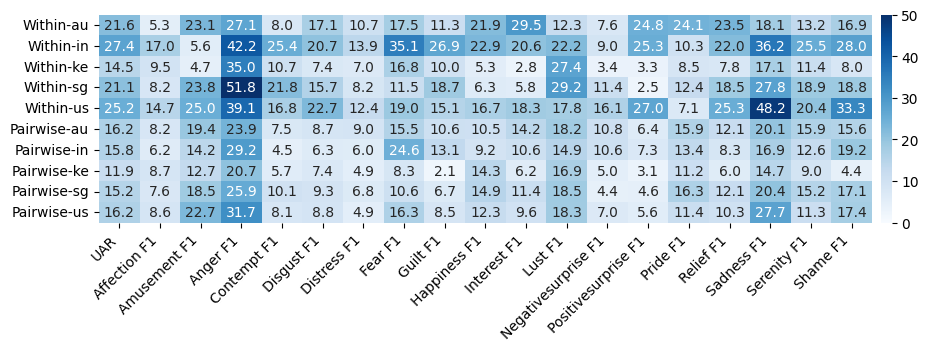

In [43]:
table_cc = d_18class["oi_pair_cc"][0].mean().unstack("metric")[metrics].mul(100)
table_wc = d_18class["wc_oi"][0].mean().unstack("metric")[metrics].mul(100)
table = pd.concat([table_wc, table_cc], keys=["Within", "Pairwise"]).rename(index=RENAMES, columns=RENAMES)

fig, ax = plt.subplots(figsize=(len(table.columns) / 1.6, len(table) / 3.7))
sns.heatmap(table, vmin=0, vmax=50, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"aspect": 20, "pad": 0.01}, ax=ax)
ax.set(xlabel=None, ylabel=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

# Analysis

In [44]:
dfs_10class = {k: pd.concat(d_10class[k], keys=[features], names=["features"]) for k in d_10class}
dfs_10class = {k: v.stack(list(range(v.columns.nlevels - 1))).reset_index() for k, v in dfs_10class.items()}
for k in dfs_10class:
    dfs_10class[k][list(scoring_10class)] *= 100

dfs_18class = {k: pd.concat(d_18class[k], keys=[features], names=["features"]) for k in d_18class}
dfs_18class = {k: v.stack(list(range(v.columns.nlevels - 1))).reset_index() for k, v in dfs_18class.items()}
for k in dfs_18class:
    dfs_18class[k][list(scoring_18class)] *= 100

dfs_18class["wc_wi"].head()

metric,features,experiment,country,intensity,affection_ba,affection_f1,affection_prec,affection_rec,amusement_ba,amusement_f1,...,serenity_ba,serenity_f1,serenity_prec,serenity_rec,shame_ba,shame_f1,shame_prec,shame_rec,uar,war
0,wav2vec2_audeering_ft_c_mean,0,AUS,high,77.777778,0.0,0.0,0.0,88.888889,0.000000,...,94.444444,0.0,0.000000,0.0,88.888889,0.0,0.0,0.0,22.222222,22.222222
1,wav2vec2_audeering_ft_c_mean,0,AUS,low,94.444444,0.0,0.0,0.0,94.444444,0.000000,...,94.444444,0.0,0.000000,0.0,94.444444,0.0,0.0,0.0,22.222222,22.222222
2,wav2vec2_audeering_ft_c_mean,0,AUS,medium,94.444444,0.0,0.0,0.0,94.444444,66.666667,...,94.444444,0.0,0.000000,0.0,94.444444,0.0,0.0,0.0,22.222222,22.222222
3,wav2vec2_audeering_ft_c_mean,0,IND,high,94.444444,0.0,0.0,0.0,83.333333,0.000000,...,88.888889,50.0,33.333333,100.0,88.888889,0.0,0.0,0.0,33.333333,33.333333
4,wav2vec2_audeering_ft_c_mean,0,IND,low,94.444444,0.0,0.0,0.0,83.333333,0.000000,...,88.888889,0.0,0.000000,0.0,83.333333,0.0,0.0,0.0,5.555556,5.555556


## Summary tables

In [45]:
metric = "uar"

def summary_tables(dfs, keys, gb):
    table = []
    pd.concat(dfs).loc[keys].groupby("country")[metric].mean()
    s = ""
    for k in keys:
        sub = dfs[k][dfs[k]["features"] == features]
        overall = sub[metric].agg(["mean", "sem"])
        s += f"{overall['mean']:.1f} ({overall['sem']:.1f}) & "
        sub = sub.groupby(gb)[metric].agg(["mean", "sem"])
        table.append(sub)
    combined = pd.concat(table, axis=1, keys=keys)
    print(combined.to_string(float_format="{:.1f}".format))
    for idx in combined.index:
        row = combined.loc[idx]
        vals = " & ".join([f"{row[k, 'mean']:.1f} ({row[k, 'sem']:.1f})" for k in keys])
        if isinstance(idx, tuple):
            idx = "\\_".join(idx)
        print(f"{idx} & {vals} \\\\")
    
    row = combined.mean().unstack()
    print(row)
    print()


print_cols = ["wc_wi", "wc_oi", "wi_logo_cc", "wi_pair_cc", "oi_logo_cc", "oi_pair_cc", "wc_pair_ci", "pair_cc_ci"]
summary_tables(dfs_18class, print_cols, "country")

summary_tables(dfs_18class, ["wc_wi", "wi_logo_cc", "wi_pair_cc", "pair_cc_ci"], "intensity")


        wc_wi     wc_oi     wi_logo_cc     wi_pair_cc     oi_logo_cc     oi_pair_cc     wc_pair_ci     pair_cc_ci    
         mean sem  mean sem       mean sem       mean sem       mean sem       mean sem       mean sem       mean sem
country                                                                                                              
AUS      27.2 1.3  21.6 1.5       22.6 0.9       19.3 1.6       20.8 0.9       16.2 1.0       23.6 1.0       17.4 0.9
IND      31.0 1.6  27.4 2.0       22.3 1.3       19.9 1.8       19.3 0.7       15.8 1.2       27.2 1.0       16.4 0.9
KEN      18.8 1.1  14.5 1.5       14.8 0.5       13.8 0.9       13.2 0.5       11.9 0.7       15.8 0.8       12.7 0.6
SIN      26.9 1.5  21.1 1.7       21.6 1.1       18.1 1.2       17.7 0.4       15.2 0.5       21.2 1.1       16.4 0.7
USA      31.5 1.7  25.2 2.5       25.4 1.3       19.4 1.4       21.5 0.8       16.2 1.0       25.5 1.2       16.7 0.9
AUS & 27.2 (1.3) & 21.6 (1.5) & 22.6 (0.9) & 19.3 (1.6) 

## Emotion metrics

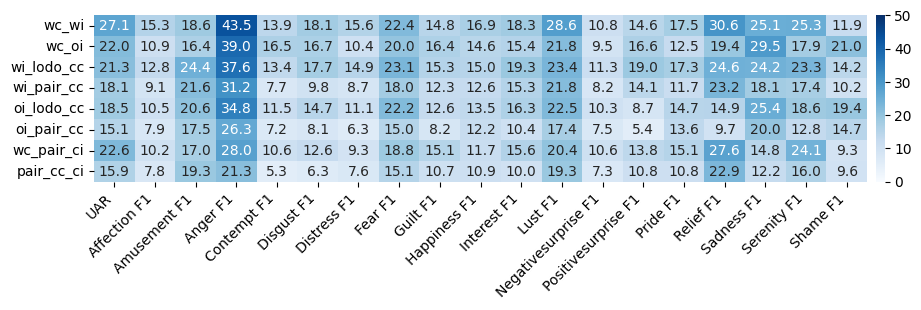

In [46]:
combined = pd.concat(dfs_18class)


def print_emo_table(features):
    subset = combined[combined["features"] == features]

    mean_per_emo_f1 = subset.groupby(level=0)[["uar"] + [f"{x}_f1" for x in classes_18]].mean()
    table = mean_per_emo_f1.loc[print_cols].rename(
        columns={f"{x}_f1": f"{x.title()} F1" for x in classes_18},
        index={x: x.replace("logo", "lodo") for x in print_cols},
    ).rename(columns={"uar": "UAR"})
    fig, ax = plt.subplots(figsize=(len(table.columns) / 1.6, len(table) / 3.7))
    sns.heatmap(table, vmin=0, vmax=50, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"aspect": 20, "pad": 0.01}, ax=ax)
    ax.set(xlabel=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.show()

print_emo_table(features)


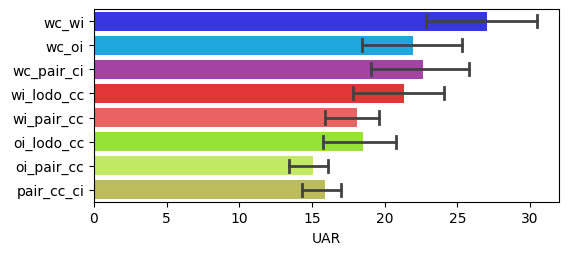

In [205]:
keys = ["wc_wi", "wc_oi", "wc_pair_ci", "wi_logo_cc", "wi_pair_cc", "oi_logo_cc", "oi_pair_cc", "pair_cc_ci"]
dfs = []
for k in keys:
    sub = d_18class[k][0].stack("country").mul(100)
    if "intensity" in sub.columns.names:
        sub = sub.stack("intensity")
    sub = sub.groupby(level="country")["uar"].mean().to_frame()
    sub = sub.assign(int="wi" if "wi" in k else "oi" if "oi" in k else "ci").set_index("int", append=True)
    sub = sub.assign(cnt="wc" if "wc" in k else "oc" if "oc" in k else "cc").set_index("cnt", append=True)
    sub = sub.assign(pair="pair" in k).set_index("pair", append=True)
    # print(sub)
    dfs.append(sub)
condition_means = pd.concat(dfs, keys=keys, names=["condition"])["uar"]
# print(condition_means)

colours = {
    "wc_wi": (0.1, 0.1, 1),
    "wc_oi": (0.0, 0.7, 1),
    "wc_pair_ci": (0.7, 0.2, 0.7),
    "wi_lodo_cc": (1, 0.1, 0.1),
    "wi_pair_cc": (1, 0.3, 0.3),
    "oi_lodo_cc": (0.6, 1, 0.1),
    "oi_pair_cc": (0.8, 1, 0.3),
    "pair_cc_ci":  (0.8, 0.8, 0.3),
}

fig, ax = plt.subplots(figsize=(6, 2.5))
sns.barplot(data=condition_means.rename(index={x: x.replace("logo", "lodo") for x in keys}).reset_index(), x="uar", y="condition", orient="h", palette=colours, errwidth=2, capsize=0.5, ax=ax)
ax.set_xlabel("UAR")
ax.set_ylabel(None)
plt.show()


## Compare conditions

wav2vec2_audeering_ft_c_mean
wc_wi 27.1 (0.7)
wc_oi 22.0 (0.9)
wi_logo_cc 21.3 (0.6)
wi_pair_cc 18.1 (0.7)
oi_logo_cc 18.5 (0.5)
oi_pair_cc 15.1 (0.4)
        wc_wi     wc_oi     wi_logo_cc     wi_pair_cc     oi_logo_cc     oi_pair_cc    
         mean sem  mean sem       mean sem       mean sem       mean sem       mean sem
country                                                                                
AUS      27.2 1.3  21.6 1.5       22.6 0.9       19.3 1.6       20.8 0.9       16.2 1.0
IND      31.0 1.6  27.4 2.0       22.3 1.3       19.9 1.8       19.3 0.7       15.8 1.2
KEN      18.8 1.1  14.5 1.5       14.8 0.5       13.8 0.9       13.2 0.5       11.9 0.7
SIN      26.9 1.5  21.1 1.7       21.6 1.1       18.1 1.2       17.7 0.4       15.2 0.5
USA      31.5 1.7  25.2 2.5       25.4 1.3       19.4 1.4       21.5 0.8       16.2 1.0
AUS & 27.2 (1.3) & 21.6 (1.5) & 22.6 (0.9) & 19.3 (1.6) & 20.8 (0.9) & 16.2 (1.0) \\
IND & 31.0 (1.6) & 27.4 (2.0) & 22.3 (1.3) & 19.9 (1.8) & 19

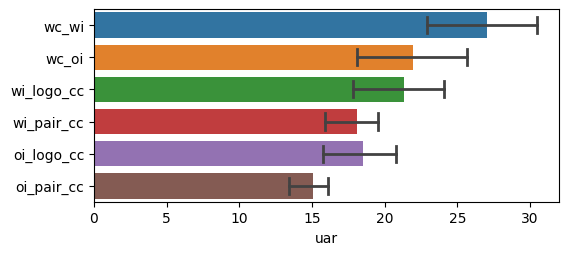

In [175]:
metric = "uar"

def compare_conditions(keys, groups):
    gbs = [dfs_18class[k].groupby("features") for k in keys]
    print(features)
    table = []
    for k, gb in zip(keys, gbs):
        sub = gb.get_group(features)
        overall = sub[metric].agg(["mean", "sem"])
        print(k, f"{overall['mean']:.1f} ({overall['sem']:.1f})")
        sub = sub.groupby(groups)[metric].agg(["mean", "sem"])
        table.append(sub)
    combined = pd.concat(table, axis=1, keys=keys)
    means = combined.xs("mean", level=1, axis=1)
    means.columns.name = "condition"

    print(combined.to_string(float_format="{:.1f}".format))
    for idx in combined.index:
        row = combined.loc[idx]
        vals = " & ".join(
            [f"{row[k, 'mean']:.1f} ({row[k, 'sem']:.1f})" for k in keys]
        )
        print(f"{idx} & {vals} \\\\")

    anova_res = pg.rm_anova(means, detailed=True)
    print(anova_res.to_string())

    n_pairs = len(keys) * (len(keys) - 1) // 2
    for k1, k2 in combinations(keys, 2):
        res = pg.ttest(means[k1], means[k2], paired=True)
        if res.loc["T-test", "p-val"] < 0.05 / n_pairs:
            print(k1, k2)
            print(res.to_string())
    print()

    fig, ax = plt.subplots(figsize=(6, 2.5))
    # sns.boxplot(ax=ax, data=means, orient="h", whis=(0, 100))
    sns.barplot(ax=ax, data=means, orient="h", errwidth=2, capsize=0.5)
    ax.set_xlabel(f"{metric}")
    ax.set_ylabel(None)
    plt.show()


# RQ 1
compare_conditions(
    ["wc_wi", "wc_oi", "wi_logo_cc", "wi_pair_cc", "oi_logo_cc", "oi_pair_cc"],
    "country",
)


wav2vec2_audeering_ft_c_mean
wi_pair_cc 18.1 (0.7)
wc_pair_ci 22.6 (0.5)
pair_cc_ci 15.9 (0.4)
        wi_pair_cc     wc_pair_ci     pair_cc_ci    
              mean sem       mean sem       mean sem
country                                             
AUS           19.3 1.6       23.6 1.0       17.4 0.9
IND           19.9 1.8       27.2 1.0       16.4 0.9
KEN           13.8 0.9       15.8 0.8       12.7 0.6
SIN           18.1 1.2       21.2 1.1       16.4 0.7
USA           19.4 1.4       25.5 1.2       16.7 0.9
AUS & 19.3 (1.6) & 23.6 (1.0) & 17.4 (0.9) \\
IND & 19.9 (1.8) & 27.2 (1.0) & 16.4 (0.9) \\
KEN & 13.8 (0.9) & 15.8 (0.8) & 12.7 (0.6) \\
SIN & 18.1 (1.2) & 21.2 (1.1) & 16.4 (0.7) \\
USA & 19.4 (1.4) & 25.5 (1.2) & 16.7 (0.9) \\
   Source          SS  DF         MS          F    p-unc  p-GG-corr       ng2       eps sphericity   W-spher   p-spher
0  Within  118.299824   2  59.149912  23.775295  0.00043   0.008137  0.505077  0.500953      False  0.003806  0.000235
1   Error   1

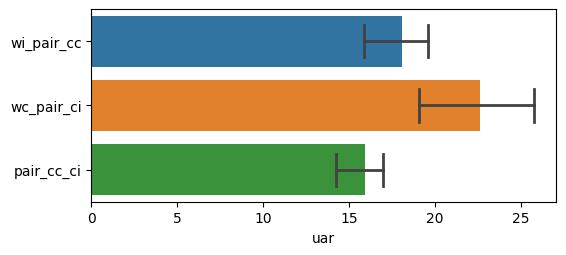

In [23]:
compare_conditions(["wi_pair_cc", "wc_pair_ci", "pair_cc_ci"], ["country"])

In [26]:
keys = ["wc_wi", "wi_pair_cc", "wi_logo_cc"]

mean_cntry_int = {k: dfs_18class[k].pivot_table(values=metric, index=["country", "intensity"], columns="features") for k in keys}

for cond in ["wi_pair_cc", "wi_logo_cc"]:
    print(cond)
    diff = mean_cntry_int["wc_wi"] - mean_cntry_int[cond]

    # anova_res = pg.rm_anova(diff.unstack(level="intensity"), detailed=True)
    # print(anova_res.to_string())
    # print()

    diff_feat = diff[features].unstack(level="intensity")
    print(diff_feat.agg(["mean", "sem"]))

    print(pg.ttest(diff_feat["high"], diff_feat["low"]).to_string())

    anova_res = pg.rm_anova(diff_feat, detailed=True)
    print(anova_res.to_string())
    print()

wi_pair_cc
intensity      high       low    medium
mean       7.642909  9.392544  9.885879
sem        0.979222  0.650611  2.579612
               T  dof alternative     p-val          CI95%   cohen-d   BF10     power
T-test -1.488218    8   two-sided  0.175014  [-4.46, 0.96]  0.941232  0.921  0.259413
   Source         SS  DF        MS         F     p-unc       ng2       eps
0  Within  13.892521   2  6.946261  0.846958  0.463834  0.079557  0.552582
1   Error  65.611344   8  8.201418       NaN       NaN       NaN       NaN

wi_logo_cc
intensity      high       low    medium
mean       3.961623  7.131579  6.151230
sem        0.949504  0.723632  1.524824
              T  dof alternative     p-val           CI95%   cohen-d BF10     power
T-test -2.65531    8   two-sided  0.029016  [-5.92, -0.42]  1.679365  2.6  0.644351
   Source         SS  DF         MS         F     p-unc       ng2       eps
0  Within  26.340142   2  13.170071  2.997726  0.106761  0.259903  0.661489
1   Error  35.146825

In [14]:
keys = ["wc_wi", "wi_pair_cc", "wi_logo_cc"]

mean_cntry_int = {k: dfs_18class[k].pivot_table(values=metric, index=["country", "intensity"], columns="features") for k in keys}

for cond in keys:
    print(cond)
    diff = mean_cntry_int[cond]

    # anova_res = pg.rm_anova(diff.unstack(level="intensity"), detailed=True)
    # print(anova_res.to_string())
    # print()

    diff_feat = diff[features].unstack(level="intensity")
    print(diff_feat.agg(["mean", "sem"]))

    print(pg.ttest(diff_feat["high"], diff_feat["low"], alternative="greater").to_string())
    print()

wc_wi
intensity      high        low     medium
mean       28.68750  24.916667  27.582516
sem         2.67159   1.102046   3.197267
               T  dof alternative    p-val        CI95%   cohen-d   BF10    power
T-test  1.304802    8     greater  0.11412  [-1.6, inf]  0.825229  1.612  0.32634

wi_pair_cc
intensity       high        low     medium
mean       21.044591  15.524123  17.696637
sem         1.770223   0.670378   1.176270
               T  dof alternative     p-val       CI95%   cohen-d   BF10     power
T-test  2.916397    8     greater  0.009699  [2.0, inf]  1.844491  6.725  0.844466

wi_logo_cc
intensity       high        low     medium
mean       24.725877  17.785088  21.431287
sem         2.235986   1.144787   1.976339
               T  dof alternative     p-val        CI95%   cohen-d  BF10    power
T-test  2.763047    8     greater  0.012279  [2.27, inf]  1.747505  5.78  0.80904

